In [352]:
from setup_notebook import setup_project_path
setup_project_path()

In [353]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [354]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [355]:
data_dir = PROCESSED_DATA_DIR
model_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [356]:
df_KPI = pd.read_csv('../data/KPIs_data_processed_2025-09-01.csv')
df_KPI = df_KPI[df_KPI.backtesting_limit>=360]
# print(df_KPI.shape)

In [357]:
model = lightgbm.Booster(model_file = os.path.join(model_dir,'lgbm_cbr_model_2025-09-23.txt'))

In [358]:
cols_with_prefix = ['frr', 'repayment_speed', 'avg_cum_days_disabled',
                  'at_risk_rate', 'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate']

df_long = (pd.wide_to_long(
    df_KPI,
    stubnames=cols_with_prefix,
    i=["accounts_group", "reg_month", "country", "product_group", "area", "primary_product"],
    j="backtesting",
    sep="_",
    suffix=r"\d+"
).reset_index()
.dropna(subset=cols_with_prefix)
)

df_long = df_long[df_long.backtesting>=360].sample(frac=1)

In [359]:
X = df_long[["avg_planned_repayment_days", "backtesting", "frr", "repayment_speed", \
             "avg_cum_days_disabled", "at_risk_rate", "disabled_gt_two_week_rate", "unlocked_rate", "disabled_rate", \
                "avg_upfront_price_usd", "avg_unlock_price_usd"]]
print(X.shape)

X 

(730194, 11)


,avg_planned_repayment_days,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
820755,629,360,0.467649,0.8169,67.0,0.000000,0.000000,0.000000,0.200000,50.0,491.0
460566,322,450,0.646085,0.6460,217.0,0.000000,0.000000,0.500000,0.500000,15.0,138.0
38978,233,630,1.000000,0.6219,187.0,0.000000,1.000000,0.000000,1.000000,34.0,180.0
113067,280,540,0.866602,0.8666,162.0,0.000000,0.172727,0.609091,0.336364,8.0,44.0
128037,278,540,1.000000,1.0000,1.0,0.000000,0.000000,1.000000,0.000000,19.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...
1185789,367,720,1.000000,1.0000,117.0,0.000000,0.000000,1.000000,0.000000,6.0,102.0
800747,402,540,0.737412,0.7374,120.0,0.000000,0.500000,0.500000,0.500000,3.0,60.0
673855,368,360,0.545666,0.5578,129.0,0.015385,0.165414,0.015038,0.533835,4.0,64.0
316475,371,360,0.738782,0.7610,87.0,0.000000,0.000000,0.000000,0.166667,13.0,47.0


In [360]:
y_pred = model.predict(X)

df_long_copy = df_long.copy()
df_long_copy['predicted_frr'] = y_pred
df_long_copy['predicted_revenue_USD'] = np.round(df_long_copy['predicted_frr']*df_long_copy['total_follow_on_revenue_usd'],2)

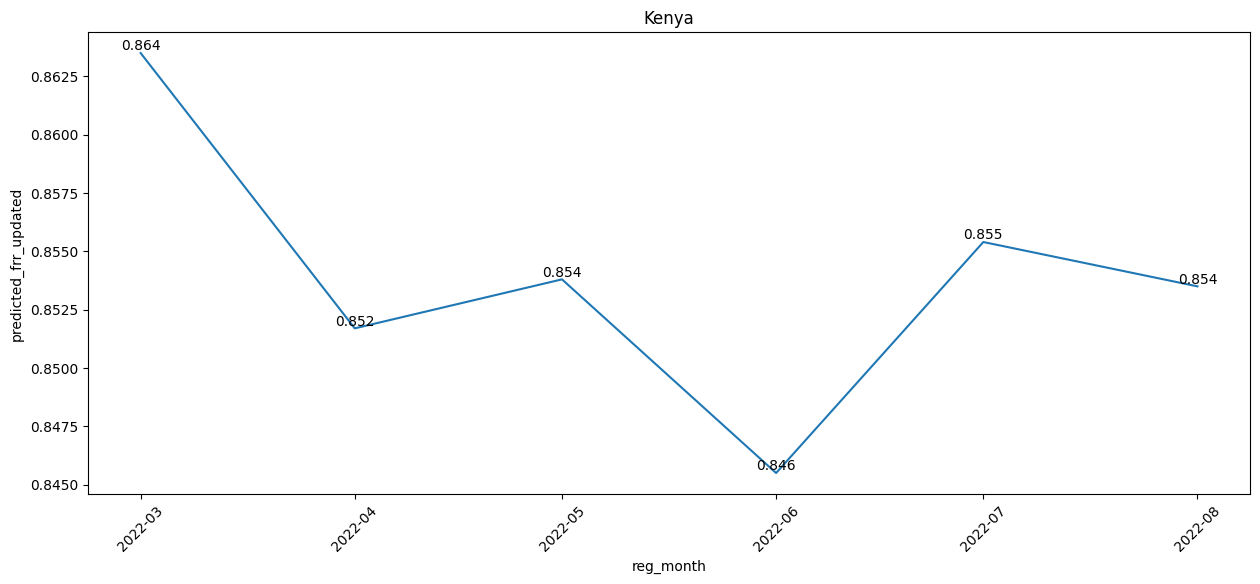

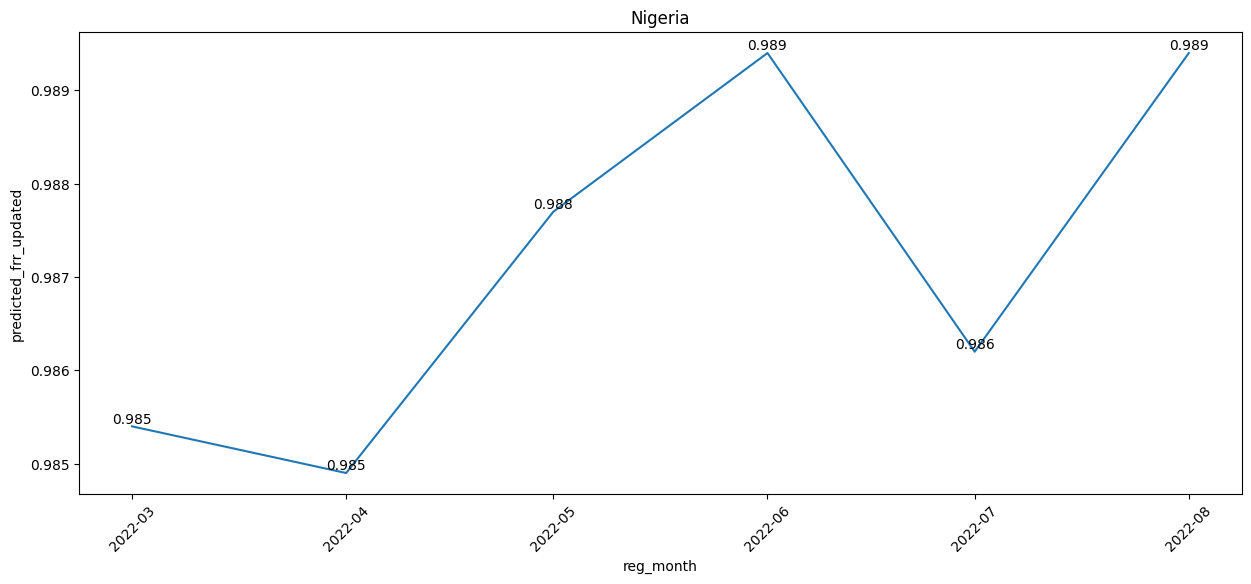

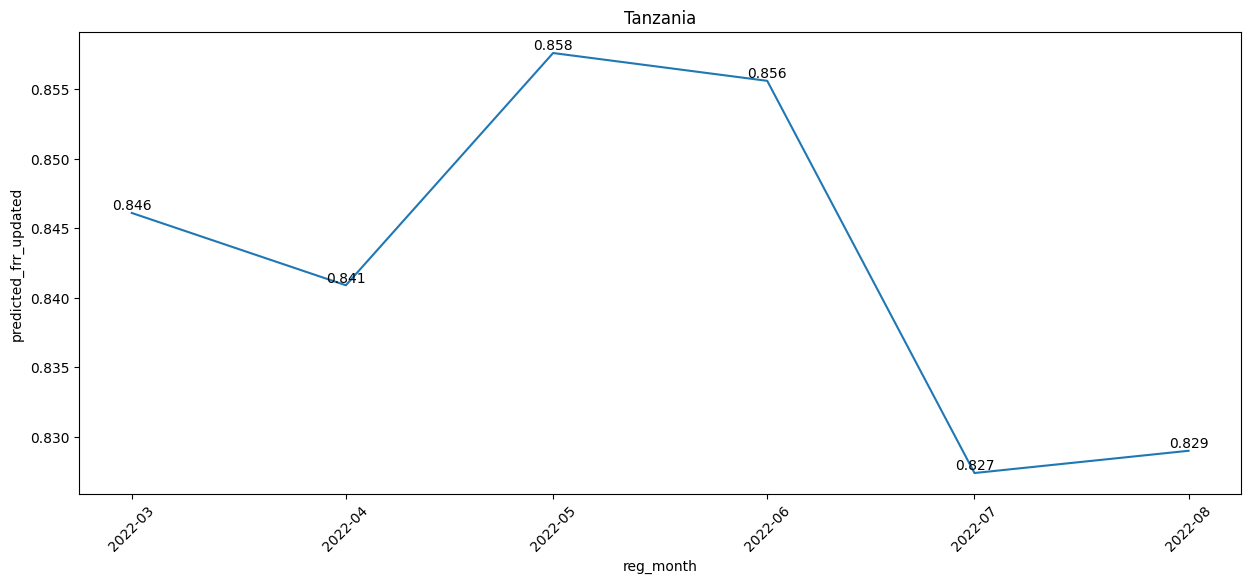

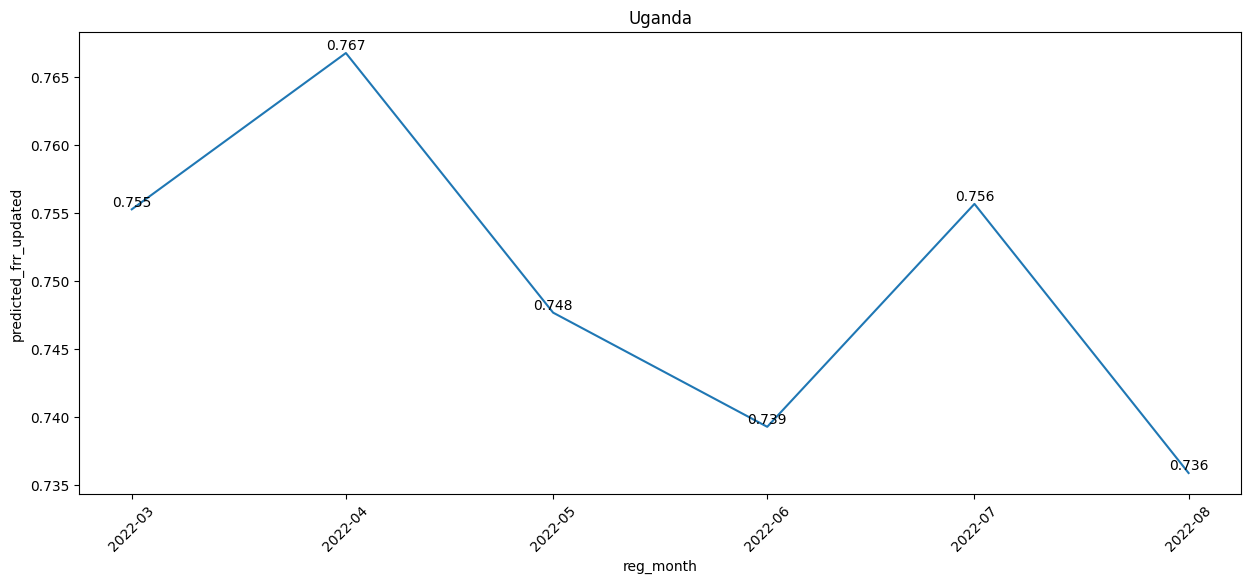

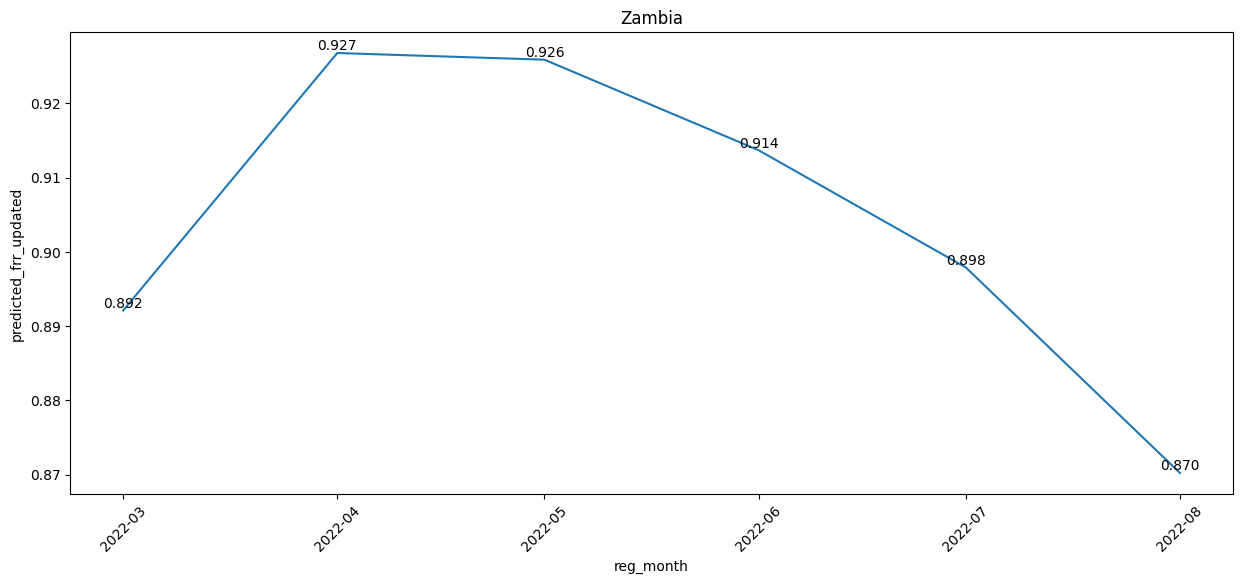

In [362]:
df_country = df_long_copy.groupby(["reg_month", "country", 'backtesting']).agg(
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["predicted_frr_updated"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["reg_month"] = pd.to_datetime(df_country["reg_month"], format="%Y-%m")
for country in ['Kenya','Nigeria','Tanzania','Uganda','Zambia']:
    plt.figure(figsize=(15, 6))
    subset = (df_country[(df_country.country==country) 
                         & (df_country.reg_month>="2022-03-01")
                         & (df_country.reg_month<="2022-08-01") 
                         & (df_country.backtesting==450)])
    
    ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr_updated")
    for x, y in zip(subset["reg_month"], subset["predicted_frr_updated"]):
        ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()